### Set cover problem

Let $G = (V,E,s)$ be a signed graph and $k$ a positive scalar satisfying $k \in \{1, \ldots, n\}$.

An edge $e \in E$ is called negative if $s(e) = −1$ and positive if $s(e) = +1$. 

Let $E^{-}$ and $E^{+}$ denote, respectively, the sets of negative and positive edges in a signed graph. 

For a vertex set $S \subseteq V$ , let $E[S] = \{ (i,j) \in E \ | \ i,j \in S \}$ denote the subset of edges induced by $S$.

Let $S[i]$ the partition $i$ the $G$.

$
\lambda_{S} = 
\begin{cases}
1, & \text{ if the set} S \text{ is in the partition } i \\
0, & \text{ otherwise } 
\end{cases} 
\forall S \in 2^{V(G)}
$

$
y_{uv} = 
\begin{cases}
1, & \text{ if the edge } uv \text{ is removed } \\
0, & \text{ otherwise }. 
\end{cases}
\forall uv \in E(G)
$

$$
\begin{align}
\min \quad & \sum\limits_{uv \in E(G)} y_{uv} & \\
st \quad & \sum_{S \in \mathcal{S}} \lambda_{S} = k \\
&\sum_{S \in \mathcal{S}(v)} \lambda_{S} \geq 1 \quad \forall v \in V(G) \\
& \lambda_{s} \leq y_{uv} \quad \forall uv \in E^{-}(G); \forall s \in \mathcal{S}(\{v,u\}) \\
& \lambda_{S_1} + \lambda_{S_1} \leq 1 + y_{uv} \quad \forall uv \in E^{+}(G), \forall S_1 \in \mathcal{S}(v), \forall S_2 \in \mathcal{S}(u) \\
& \lambda_{S} \in \{0,1\} \quad \forall S \in \mathcal{S} \\
& y_{uv} \in \{0,1\} \quad \forall uv \in E(G)
\end{align}
$$

In [40]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
import itertools
from itertools import chain, combinations

In [41]:
def graph_ex():
    G = nx.Graph()
    #G.add_nodes_from([1,2,3,4,5,6])
    edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1), (2,5,-1), (2,6,+1), (3,5,+1), (3,6,-1), (4,5,+1), (5,6,-1)]
    G.add_weighted_edges_from(edges)

    return G

In [42]:
def graph_ex1():
    G = nx.Graph()
    #G.add_nodes_from([1,2,3,4,5,6])
    edges = [(1,2,+1), (1,4,-1), (2,3,-1), (2,4,-1)]
    G.add_weighted_edges_from(edges)

    return G

In [82]:
def plot_graph_ex(G):
    plt.figure(figsize=(12, 8))
    #nx.draw_planar(G, with_labels = "True")
    pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}
    nx.draw(G, pos, with_labels="True")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

In [83]:
def comb(nodes):

    lcomb = sum([list(map(list, combinations(nodes, i))) for i in range(len(nodes) + 1)], [])
    #lcomb.remove([])

    return lcomb

In [84]:
def set_S(lcomb):
    S = dict()
    for key, value in enumerate(lcomb):
        S[key] = value

    return S

In [85]:
def set_Sv(G,S):

    Sv = dict()
    for v in G.nodes:
        keys = [key for key, value in S.items() if v in value]
        Sv[v] = keys

    return Sv

In [86]:
def set_Suv(G,S):
    Suv = dict()
    for e in G.edges:
        keys = [key for key, value in S.items() if (e[0] in value and e[1] in value)]
        Suv[e] = keys

    return Suv

In [87]:
def edgesEN(G):
    EP = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0]
    EN = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0]

    return EP, EN

In [88]:
def read_instance(instance):
    with open(instance, 'r') as file: 
        lines = file.readlines()

    lines = [a.strip() for a in lines]

    values = lines[0].split()
    n, m = int(values[0]), int(values[1])

    #print("n =", n)
    #print("m =", m)

    G = nx.Graph()

    for k in range(n):
        G.add_node(k)

    for e in range(1,m+1):
        values = lines[e].split()
        i, j, val = int(values[0]), int(values[1]), int(values[2])
        G.add_edge(i, j, weight=val)

    return G


In [89]:
def plotGraph(G, pos):
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [90]:
def position(G):
    #seed = 20532
    pos = nx.spring_layout(G)
    #pos=nx.random_layout(G)
    #pos=nx.circular_layout(G)
    #pos=nx.spectral_layout(G)
    #pos=nx.spiral_layout(G)
    #pos = nx.spring_layout(G, seed=seed)

    return pos

In [91]:
def setcover_mip(G, k, EP, EN, S, Sv, Suv):

    nodes = G.nodes()
    edges = G.edges()
    
    method = "mip"

    #modelnx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    model = gp.Model()

    # silent/verbose mode
    model.Params.OutputFlag = 0

    # variables
    if method == "mip":
        y = model.addVars(edges,vtype=gp.GRB.BINARY, name="y")
        l = model.addVars(len(S),vtype=gp.GRB.BINARY, name="l")

    model.update()

    #objective function
    obj = 0
    for e in edges:
        obj += y[e]
         
    model.setObjective(obj, gp.GRB.MINIMIZE)

    # constraints

    lkey = [key for key, value in S.items()]
    constr = 0
    for s in lkey:
        constr += l[s] 
    model.addConstr(constr <= k, "constr9")

    for v in nodes:
        constr = 0
        for s in Sv[v]:
            constr += l[s] 
        model.addConstr(constr >= 1.0, "constr10")

    for e in EN:
        for s in Suv[e]:
            model.addConstr(l[s] <= y[e], "constr11")

    for e in EP:
        for s1 in Sv[e[0]]:
            for s2 in Sv[e[1]]:
                model.addConstr(l[s1] + l[s2] <= 1 + y[e], "constr12")

    if method != "mip":
        for v in model.getVars():
            v.setAttr('vtype', 'C')

    model.write("setcover_mip.lp")
    
    model.optimize()
         
    tmp = 0
    if model.status == gp.GRB.OPTIMAL:
        tmp = 1
 
    objval = model.objVal
    runtime = model.Runtime
    status = tmp
    if method == "mip":
        objbound = model.objBound
        mipgap = model.MIPGap
        nodecount = model.NodeCount

    lval = {}
    for v in lkey:
        lval[v] = l[v].x

    yval = {}
    for e in edges:
        yval[e] = y[e].x

    El = []
    for key, value in lval.items():
        if value > 0.5:
            El.append(key)

    Ey = []
    for key, value in yval.items():
        if value > 0.5:
            Ey.append(key)

    model.dispose()

    return objval, objbound, mipgap, nodecount, runtime, status, El, Ey

In [92]:
#random_n20_k2_pos30_neg5_err5_1
#random_n20_k2_pos30_neg5_err5_2
#random_n20_k2_pos30_neg5_err5_3
#random_n20_k2_pos30_neg5_err5_4
#random_n20_k2_pos30_neg5_err5_5

#random_n60_k2_pos30_neg5_err5_1
#random_n60_k2_pos30_neg5_err5_2
#random_n60_k2_pos30_neg5_err5_3
#random_n60_k2_pos30_neg5_err5_4
#random_n60_k2_pos30_neg5_err5_5

# random_n60_k3_pos30_neg5_err5_1

# random_n60_k4_pos30_neg5_err5_1

# random_n60_k5_pos30_neg5_err5_1

#instance = f"../data/kmbs/instances/RANDOM/random_n60_k3_pos30_neg5_err5_1.g"

#G = read_instance(instance)

G = graph_ex()


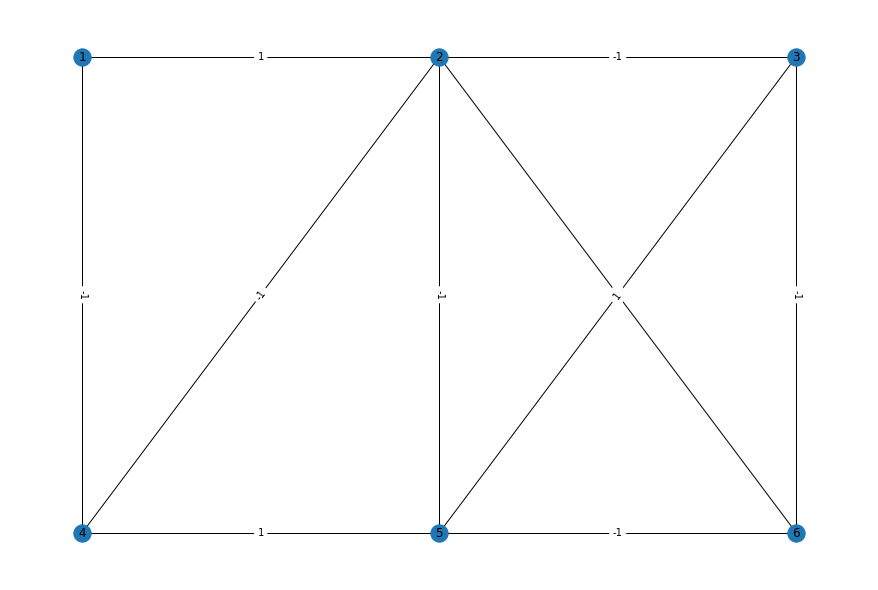

In [93]:
plot_graph_ex(G)

In [94]:
n = G.number_of_nodes()
m = G.number_of_edges()

nodes = G.nodes()
edges = G.edges()

In [95]:
print("n =", n)
print("m =", m)
print(nodes)
print(edges)

n = 6
m = 10
[1, 2, 4, 3, 5, 6]
[(1, 2), (1, 4), (2, 3), (2, 4), (2, 5), (2, 6), (4, 5), (3, 5), (3, 6), (5, 6)]


In [96]:
EP, EN = edgesEN(G)
lcomb = comb(nodes)
S = set_S(lcomb)
Sv = set_Sv(G,S)
Suv = set_Suv(G,S)

In [97]:
for key, value in S.items():
    print(f"{key}: {value}")

0: []
1: [1]
2: [2]
3: [4]
4: [3]
5: [5]
6: [6]
7: [1, 2]
8: [1, 4]
9: [1, 3]
10: [1, 5]
11: [1, 6]
12: [2, 4]
13: [2, 3]
14: [2, 5]
15: [2, 6]
16: [4, 3]
17: [4, 5]
18: [4, 6]
19: [3, 5]
20: [3, 6]
21: [5, 6]
22: [1, 2, 4]
23: [1, 2, 3]
24: [1, 2, 5]
25: [1, 2, 6]
26: [1, 4, 3]
27: [1, 4, 5]
28: [1, 4, 6]
29: [1, 3, 5]
30: [1, 3, 6]
31: [1, 5, 6]
32: [2, 4, 3]
33: [2, 4, 5]
34: [2, 4, 6]
35: [2, 3, 5]
36: [2, 3, 6]
37: [2, 5, 6]
38: [4, 3, 5]
39: [4, 3, 6]
40: [4, 5, 6]
41: [3, 5, 6]
42: [1, 2, 4, 3]
43: [1, 2, 4, 5]
44: [1, 2, 4, 6]
45: [1, 2, 3, 5]
46: [1, 2, 3, 6]
47: [1, 2, 5, 6]
48: [1, 4, 3, 5]
49: [1, 4, 3, 6]
50: [1, 4, 5, 6]
51: [1, 3, 5, 6]
52: [2, 4, 3, 5]
53: [2, 4, 3, 6]
54: [2, 4, 5, 6]
55: [2, 3, 5, 6]
56: [4, 3, 5, 6]
57: [1, 2, 4, 3, 5]
58: [1, 2, 4, 3, 6]
59: [1, 2, 4, 5, 6]
60: [1, 2, 3, 5, 6]
61: [1, 4, 3, 5, 6]
62: [2, 4, 3, 5, 6]
63: [1, 2, 4, 3, 5, 6]


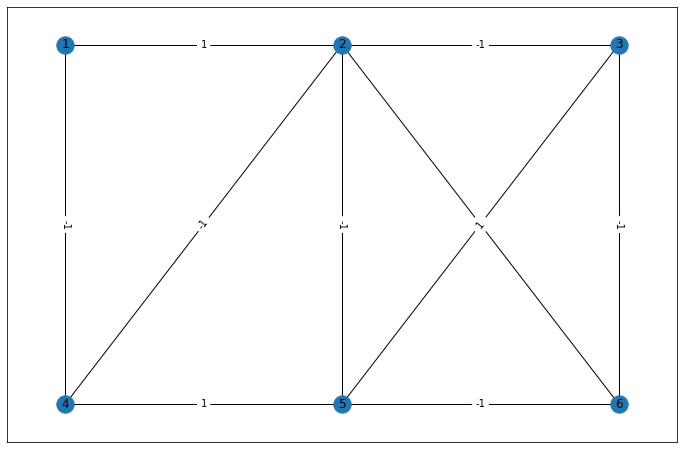

In [98]:
#pos = position(G)
pos = {1:(0,0), 2:(2,0), 3:(4,0), 4:(0,-1), 5:(2,-1), 6:(4,-1)}
plotGraph(G,pos)

In [99]:
HP = nx.Graph()
HN = nx.Graph()

HP.add_nodes_from(G)
HN.add_nodes_from(G)

HP.add_edges_from(EP)
HN.add_edges_from(EN)

print(f"G : {G.number_of_nodes()}, {G.number_of_edges()}")
print(f"HP : {HP.number_of_nodes()}, {HP.number_of_edges()}")
print(f"HN : {HN.number_of_nodes()}, {HN.number_of_edges()}")

G : 6, 10
HP : 6, 4
HN : 6, 6


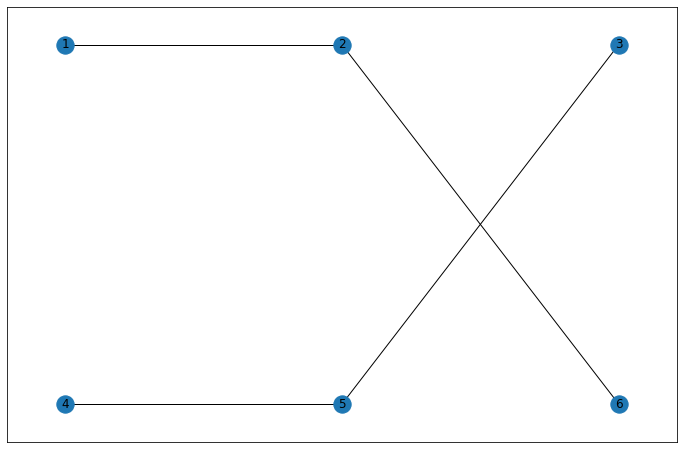

In [100]:
plotGraph(HP, pos)

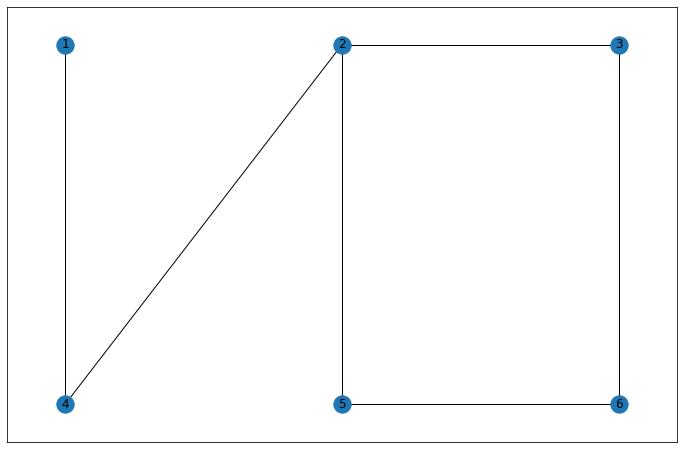

In [101]:
plotGraph(HN,pos)

In [102]:
k = 3

objval, objbound, mipgap, nodecount, runtime, status, El, Ey = setcover_mip(G, k, EP, EN, S, Sv, Suv)
    
print("ub = ", objval)
print("time = ", runtime)
print("status = ", status)
print("lb = ", objbound)
print("gap = ", mipgap)
print("nodes = ", nodecount)


ub =  4.0
time =  0.3061220645904541
status =  1
lb =  4.0
gap =  0.0
nodes =  170.0


In [103]:
print(El)

[2, 18, 29]


In [104]:
partition = []
for i in El:
    partition.append(set(S[i]))
    
partition

[{2}, {4, 6}, {1, 3, 5}]

In [105]:
print(Ey)

[(1, 2), (2, 6), (4, 5), (3, 5)]


In [106]:
nx.community.is_partition(G, partition)

True

In [107]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

for key, value in partition_map.items():
    print(f"{key}: {value}")

2: 0
4: 1
6: 1
1: 2
3: 2
5: 2


In [108]:
color_map = []
for node in G:
    if partition_map[node] == 0:
        color_map.append('gray')
    elif partition_map[node] == 1:
        color_map.append('green')
    else:
        color_map.append('yellow')

#node_colors = [partition_map[n] for n in G.nodes]

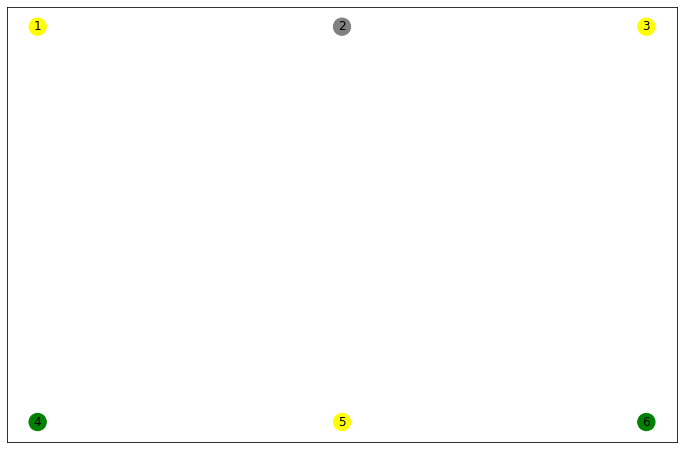

In [109]:
HP.remove_edges_from(Ey)
plt.figure(figsize=(12, 8))        
nx.draw_networkx(HP, pos, node_size=300, node_color=color_map, with_labels=True)
plt.show()

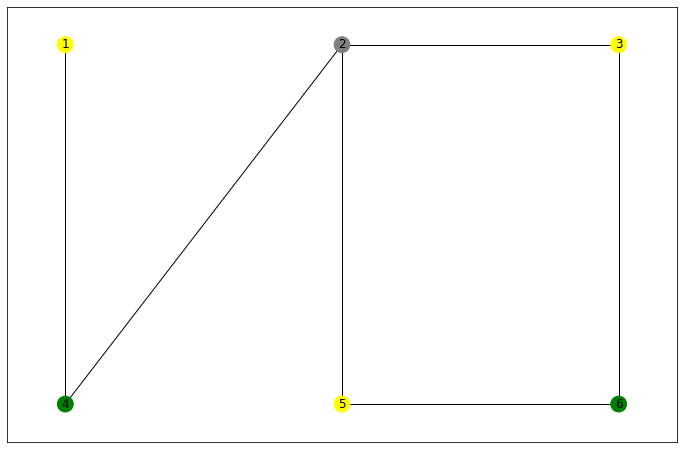

In [110]:
HN.remove_edges_from(Ey)
plt.figure(figsize=(12, 8))        
nx.draw_networkx(HN, pos, node_size=250, node_color=color_map, with_labels=True)
plt.show()

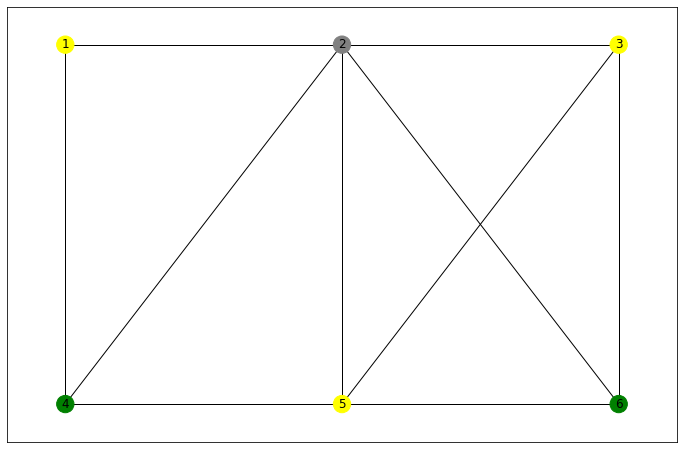

In [111]:
plt.figure(figsize=(12, 8))        
nx.draw_networkx(G, pos, node_size=300, node_color=color_map, with_labels=True)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

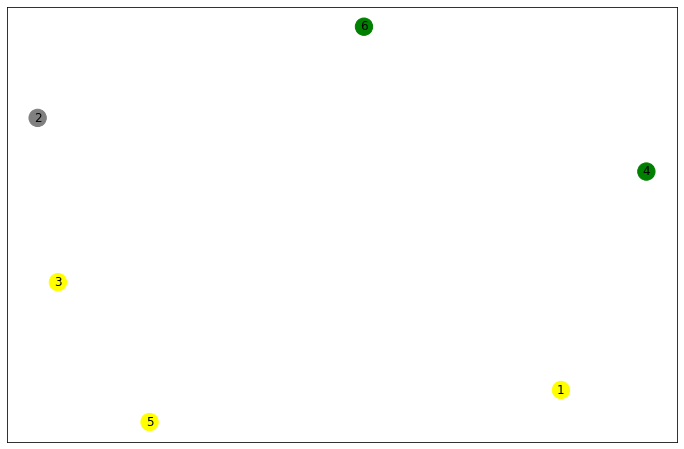

In [112]:
seed = 20532
plt.figure(figsize=(12, 8))        
pos1 = nx.spring_layout(HP, seed=seed)
nx.draw_networkx(HP, pos1, node_size=300, node_color=color_map, with_labels=True)
plt.show()

In [113]:
print(Ey)

[(1, 2), (2, 6), (4, 5), (3, 5)]


In [114]:
El

[2, 18, 29]